In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
import sys
import os
import re

# Used to accelerate plotting DAMON figures.
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

from matplotlib.colors import LogNorm, hsv_to_rgb

def find_region_id(row, df2):
    #print(row)
    #time = row['time']
    addr = row['PageFrame']
    matches = df2[
            (df2['start'] <= addr) &
            (df2['end'] > addr)
            #(df2['start_addr'] <= addr) &
            #(df2['end_addr'] >= addr)
            ]
    if not matches.empty:
        return matches.iloc[0]['rno'].astype(int) # if multiple matches, take the first
    else:
        #print("Failed! time {} addr {}".format(time,addr))
        #exit()
        return None

# Prepare a df for given PEBS sample file
def prepare_pebs_df(file):
    # Read the file line by line
    with open(file) as f:
        rows = [line.strip().split() for line in f if line.strip()]

    # Find the maximum number of columns in any row
    max_cols = max(len(row) for row in rows)

    # Pad each row so all have the same length
    #padded_rows = [row + [np.nan]*(max_cols - len(row)) for row in rows]

    # Function to pad each row with the last recorded value
    def pad_row(row, target_length):
        if len(row) < target_length:
            last_value = row[-1]
            # Extend the row with the last_value until it reaches the target length
            row = row + [last_value] * (target_length - len(row))
        return row

    # Pad each row accordingly
    padded_rows = [pad_row(row, max_cols) for row in rows]

    # Create a DataFrame
    df = pd.DataFrame(padded_rows)

    # Rename columns: first column as 'PageFrame' and remaining as 'Epoch1', 'Epoch2', ...
    df.rename(columns={0: "PageFrame"}, inplace=True)
    df.columns = ["PageFrame"] + [f"Epoch_{i}" for i in range(1, max_cols)]

    df["PageFrame"] = df["PageFrame"].apply(lambda x: hex(int(x, 16) << 21))

    # Convert epoch columns to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col])


    # Set PageFrame as index for easier time-series operations
    df.set_index("PageFrame", inplace=True)

    df = df.copy() # Improves performance? df is sparse otherwise

    # Compute the deltas across epochs
    delta_df = df.diff(axis=1)

    # For the first epoch, fill NaN with the original epoch value
    first_epoch = df.columns[0]
    delta_df[first_epoch] = df[first_epoch]

    # Reorder columns to ensure the first epoch is first
    delta_df = delta_df[df.columns]

    # Optional: Convert column names to a numeric index if desired
    # For plotting purposes, we can remove the 'Epoch_' prefix and convert to int
    delta_df.columns = [int(col.replace("Epoch_", ""))*0.5 for col in delta_df.columns]

    # If we want to use plt instead of sns, melt df into long form
    df_long = (
        delta_df
        .reset_index()
        .melt(id_vars=["PageFrame"], var_name="epoch", value_name="value")
    )
    df_long["PageFrame"] = df_long["PageFrame"].apply(lambda x: int(x,16))
    return df_long

    return delta_df

def get_reuse_distance_df(df):
    df_zero_streak_sorted = df.sort_values(by=['PageFrame', 'epoch']).reset_index(drop=True)
    
    # Container for results
    results = []
    
    # Group by PageFrame
    for pf, group in df_zero_streak_sorted.groupby('PageFrame'):
        # Mark where value == 0
        zero_mask = group['value'] == 0
    
        # Identify start of new streaks using the change in zero_mask
        streak_id = (zero_mask != zero_mask.shift()).cumsum()
    
        # For value == 0 streaks only, compute their lengths
        zero_streaks = group[zero_mask].groupby(streak_id).size()
    
        # Get the max streak length (0 if none)
        max_streak = zero_streaks.max() if not zero_streaks.empty else 0
    
        results.append({'PageFrame': pf, 'reuse_distance': max_streak})
    
    # Create a new dataframe
    streak_df = pd.DataFrame(results)
    return streak_df

def calculate_duty_cycle(df):
    # Calculate Duty Cycle
    non_zero_df = df[df['value'] != 0]
    counts = non_zero_df.groupby('PageFrame').size()
    counts.name = 'duty_cycle'
    df = df.merge(counts, on='PageFrame', how='left')
    df['duty_cycle'] = df['duty_cycle'].fillna(0).astype(int)
    df['duty_cycle_sample_count'] = len(df['epoch'].unique())
    df['duty_cycle_percent'] = (df['duty_cycle'] / len(df['epoch'].unique())*100).astype(int)
    return df

In [2]:
vma_df = (pd.read_csv('../../results/results_vma_cluster/cc_sv_memory_regions_smap_deduplicated.csv'))

next_rno = vma_df['rno'].max() + 1

vma_df['start'] = vma_df['start'].apply(lambda x: int(x,16))
vma_df['end'] = vma_df['end'].apply(lambda x: int(x,16))
print(vma_df)

    epoch  rno            start              end     inode  \
0       0    0   93824992231424   93824992243712  92030525   
1       0    1   93824992243712   93824992305152  92030525   
2       0    2   93824992305152   93824992317440  92030525   
3       0    3   93824992317440   93824992321536  92030525   
4       0    4   93824992321536   93824992325632  92030525   
5      24    5   93824992325632   93824992460800         0   
6      24    6  140726681636864  140726690025472         0   
7      24    7  140726690029568  140726698418176         0   
8      24    8  140726698422272  140726706810880         0   
9      24    9  140726706814976  140726715203584         0   
10     24   10  140726715207680  140726723596288         0   
11     24   11  140726723600384  140726731988992         0   
12    113   12  140726731993088  140726740381696         0   
13     23    6  140727233011712  140737345748992         0   
14      0    7  140737345748992  140737345912832    246393   
15     2

In [3]:
# Get only vma with no pathname (anon region) and a size over 2 MB
filtered_vma_df = (vma_df[pd.isna(vma_df['pathname']) & (vma_df['size'] >= (1<<21))])
#filtered_vma_df = vma_df
print(filtered_vma_df)
def split_large_rows(df, next_rno, size_threshold=(1<<20)):
    new_rows = []
    #next_rno = df['rno'].max() + 1  # Start new rno from max + 1

    for _, row in df.iterrows():
        if row['size'] > size_threshold:
            # Calculate number of chunks needed
            num_chunks = int(row['size'] // size_threshold)
            last_chunk_size = row['size'] % size_threshold

            # Split into chunks
            start = row['start']
            for i in range(num_chunks):
                new_row = row.copy()
                new_row['rno'] = next_rno
                new_row['start'] = start
                new_row['end'] = start + size_threshold * (1<<10)
                new_row['size'] = size_threshold
                new_rows.append(new_row)
                start += size_threshold * (1<<10)
                next_rno += 1

            # Last chunk (if any remainder)
            if last_chunk_size > 0:
                new_row = row.copy()
                new_row['rno'] = next_rno
                new_row['start'] = start
                new_row['end'] = start + last_chunk_size * (1<<10)
                new_row['size'] = last_chunk_size
                new_rows.append(new_row)
                next_rno += 1
        else:
            new_rows.append(row)

    return pd.DataFrame(new_rows)

split_vma_df = (split_large_rows(filtered_vma_df, next_rno))
print(split_vma_df)

    epoch  rno            start              end  inode pathname     size  \
13     23    6  140727233011712  140737345748992      0      NaN  9875720   

     rss_kb   pss_kb  pss_dirty  referenced  
13  9595748  9595748    9595748     9595748  
    epoch  rno            start              end  inode  pathname     size  \
13     23   42  140727233011712  140728306753536      0       NaN  1048576   
13     23   43  140728306753536  140729380495360      0       NaN  1048576   
13     23   44  140729380495360  140730454237184      0       NaN  1048576   
13     23   45  140730454237184  140731527979008      0       NaN  1048576   
13     23   46  140731527979008  140732601720832      0       NaN  1048576   
13     23   47  140732601720832  140733675462656      0       NaN  1048576   
13     23   48  140733675462656  140734749204480      0       NaN  1048576   
13     23   49  140734749204480  140735822946304      0       NaN  1048576   
13     23   50  140735822946304  140736896688128   

In [4]:
# Read in pebs data and bin in N second intervals
N = 10
df = prepare_pebs_df('../../results/results_vma_cluster/gapbs_cc_sv_samples.dat')
df['time_bin'] = (df['epoch'] // N).astype(int)
print(df)
dfs_by_interval = {
    f"{N * bin}s_to_{N * (bin + 1)}s": group.drop(columns='time_bin')
    for bin, group in df.groupby('time_bin')
}

               PageFrame  epoch  value  time_bin
0                6291456    0.5      0         0
1                8388608    0.5      0         0
2               25165824    0.5      0         0
3               27262976    0.5      0         0
4               29360128    0.5      0         0
...                  ...    ...    ...       ...
2482075  140737345748992  240.0      0        24
2482076  140737347846144  240.0     14        24
2482077  140737349943296  240.0      9        24
2482078  140737352040448  240.0      8        24
2482079  140737486258176  240.0      0        24

[2482080 rows x 4 columns]


In [22]:
page_stat_df = None
for df in dfs_by_interval.values():
    if df['epoch'].min() < 70:
        continue
    time_bin_df = df.copy()
    duty_df = calculate_duty_cycle(time_bin_df)
    duty_df = duty_df.drop_duplicates(subset='PageFrame')[['PageFrame', 'duty_cycle', 'duty_cycle_sample_count', 'duty_cycle_percent']]
    #duty_avg_df = (df.drop(columns=['epoch', 'duty_cycle_sample_count', 'duty_cycle', 'value']).groupby('PageFrame', as_index=False).mean().astype(int))

    #print(duty_df)
    streak_df = get_reuse_distance_df(time_bin_df)
    time_bin_df = time_bin_df.merge(streak_df, on='PageFrame', how='left')
    
    #print(streak_df)
    #break
    page_stat_df = time_bin_df.groupby('PageFrame').agg(
        {
            'value': ['mean', 'std', 'min', 'max'],
            'reuse_distance': ['mean']
        }
    )
    #print('time bin...---------')
    #print(time_bin_df)
    #print('page_stat ..........')
    #print(page_stat_df)

    # Combine duty cycle info with access statistics
    page_stat_df.columns = ['_'.join(col) for col in page_stat_df.columns]
    page_stat_df = page_stat_df.merge(duty_df, on='PageFrame', how='left')
    page_stat_df = page_stat_df.reset_index(drop=True)

    # Apply region numbers, do this last on smaller aggregated data set because it takes a while.
    page_stat_df['rno'] = page_stat_df.apply(lambda row: find_region_id(row, split_vma_df), axis=1)
    #page_stat_df['rno'] = page_stat_df['rno'].fillna(-1)
    #print(page_stat_df)
    page_stat_df = page_stat_df.dropna().reset_index(drop=True)
    page_stat_df['rno'] = page_stat_df['rno'].astype(int)

    if time_bin_df['epoch'].min() > 70:
        break

print(page_stat_df)

            PageFrame  value_mean    value_std  value_min  value_max  \
0     140727233282048        0.10     0.447214          0          2   
1     140727235379200        0.15     0.670820          0          3   
2     140727237476352        0.10     0.447214          0          2   
3     140727239573504        0.25     1.118034          0          5   
4     140727241670656        0.45     2.012461          0          9   
...               ...         ...          ...        ...        ...   
4817  140737335263232     2081.65  1568.699907        378       5710   
4818  140737337360384     1771.35  1528.727619        227       6520   
4819  140737339457536     1614.80  1481.477555        237       6689   
4820  140737341554688     1336.10  1219.076048        284       5627   
4821  140737343651840     1139.15  1163.953529        279       5512   

      reuse_distance_mean  duty_cycle  duty_cycle_sample_count  \
0                    15.0           1                       20   
1  

In [59]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def apply_cluster(page_stat_df):
    scaler = StandardScaler()
    features = page_stat_df.drop(columns=['PageFrame', 'rno', 'duty_cycle_sample_count', 'duty_cycle'])
    print(features)
    scaled_features = scaler.fit_transform(features)
    
    pca_col = ['pc1', 'pc2']
    pca = PCA(n_components=0.95)
    pca_df = pd.DataFrame(pca.fit_transform(scaled_features), columns=pca_col)
    
    k = 4
    kmeans = KMeans(n_clusters=k)
    #kmeans.fit(scaled_features)
    #kmeans.fit(pca_df)
    db = DBSCAN(eps=1.0, min_samples=5).fit(pca_df)
    
    #page_stat_df['cluster'] = kmeans.labels_
    page_stat_df['cluster'] = db.labels_
    page_stat_df['cluster'] = page_stat_df['cluster'].astype(int)

    print('----page_stat_df-----')
    print(page_stat_df)
    print('----------')
    print('pca_df')
    print(pca_df)
    print('-----')
    
    page_stat_df_merged = (pd.concat([page_stat_df, pca_df], axis=1))
    page_stat_df_merged['start_epoch'] = 0

    # Return new df with cluster labels and pca values
    return page_stat_df_merged

clustered_df = apply_cluster(page_stat_df.copy())
print('------')
print(clustered_df)

      value_mean    value_std  value_min  value_max  reuse_distance_mean  \
0           0.10     0.447214          0          2                 15.0   
1           0.15     0.670820          0          3                 15.0   
2           0.10     0.447214          0          2                 15.0   
3           0.25     1.118034          0          5                 15.0   
4           0.45     2.012461          0          9                 15.0   
...          ...          ...        ...        ...                  ...   
4817     2081.65  1568.699907        378       5710                  0.0   
4818     1771.35  1528.727619        227       6520                  0.0   
4819     1614.80  1481.477555        237       6689                  0.0   
4820     1336.10  1219.076048        284       5627                  0.0   
4821     1139.15  1163.953529        279       5512                  0.0   

      duty_cycle_percent  
0                      5  
1                      5  
2     

              PageFrame epoch  value  reuse_distance  cluster
344     140727233282048  80.0      0              15      0.0
345     140727235379200  80.0      0              15      0.0
346     140727237476352  80.0      0              15      0.0
347     140727239573504  80.0      0              15      0.0
348     140727241670656  80.0      0              15      0.0
...                 ...   ...    ...             ...      ...
103410  140737335263232  89.5   2723               0      5.0
103411  140737337360384  89.5   2240               0      5.0
103412  140737339457536  89.5   2011               0      5.0
103413  140737341554688  89.5   1770               0     -1.0
103414  140737343651840  89.5   1509               0     -1.0

[96440 rows x 5 columns]


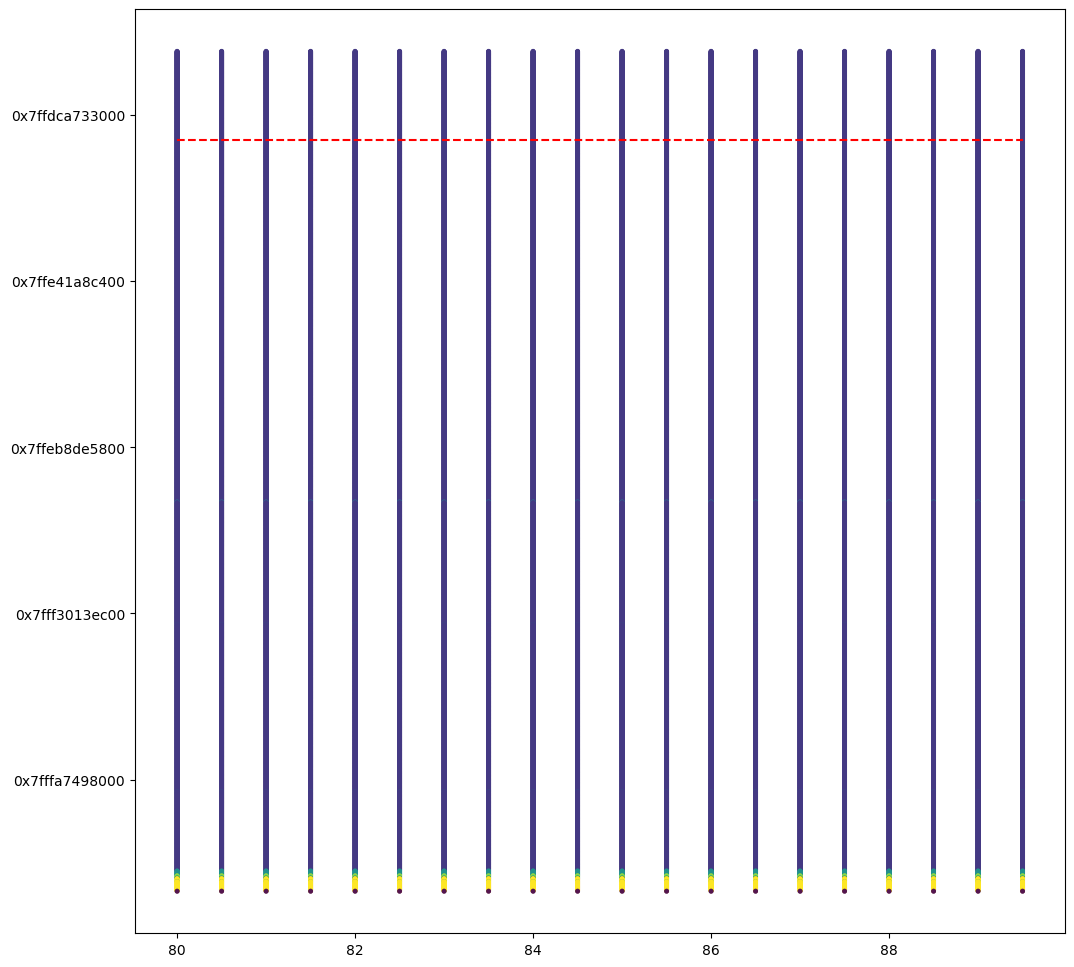

In [60]:
#time_bin_df['cluster'] = clustered
#time_bin_df['cluster'] = time_bin_df['PageFrame'].map(clustered_df.set_index('PageFrame')['cluster'])
time_bin_df1 = time_bin_df.merge(
    clustered_df[['PageFrame', 'cluster']].drop_duplicates('PageFrame'),
    on='PageFrame',
    how='left'
)
#print(clustered_df)
#time_bin_df1['cluster'] = (time_bin_df1['cluster'].fillna(-1))
time_bin_df1 = (time_bin_df1.dropna())
print(time_bin_df1)
#plt.scatter(time_bin_df1['epoch'], time_bin_df1['PageFrame'], c=time_bin_df1['cluster'])
plt.figure(figsize=(12, 12))
plt.scatter(time_bin_df1['epoch'], time_bin_df1['PageFrame'], c=time_bin_df1['cluster'], s=50, edgecolor='none', rasterized=True, alpha=0.7, marker='.')
#plt.scatter(df['time'], df['address'], s=50, edgecolor='none', rasterized=True, alpha=0.7, marker='.')
xmin = df['epoch'].min()
xmax = df['epoch'].max()
ymin = time_bin_df1['PageFrame'].min() + (1<<30)
plt.hlines(y=ymin, xmin=xmin, xmax=xmax, colors='red', linestyles='dashed')
ax = plt.gca()

# 1) Define a hex‐formatter: takes a float x and returns e.g. '0x1a3f'
hex_formatter = FuncFormatter(lambda x, pos: hex(int(x)))

# 2) Install it on the y‐axis
ax.yaxis.set_major_formatter(hex_formatter)
ax.invert_yaxis()
#sns.scatterplot(data=time_bin_df1.dropna(), y='PageFrame', x='epoch', hue='cluster', palette=sns.color_palette("tab10"))
plt.show()
#page_stat_df['rno'].fillna(-1)

            PageFrame  value_mean    value_std  value_min  value_max  \
0     140727233282048        0.10     0.447214          0          2   
1     140727235379200        0.15     0.670820          0          3   
2     140727237476352        0.10     0.447214          0          2   
3     140727239573504        0.25     1.118034          0          5   
4     140727241670656        0.45     2.012461          0          9   
...               ...         ...          ...        ...        ...   
4817  140737335263232     2081.65  1568.699907        378       5710   
4818  140737337360384     1771.35  1528.727619        227       6520   
4819  140737339457536     1614.80  1481.477555        237       6689   
4820  140737341554688     1336.10  1219.076048        284       5627   
4821  140737343651840     1139.15  1163.953529        279       5512   

      reuse_distance_mean  duty_cycle  duty_cycle_sample_count  \
0                    15.0           1                       20   
1  

/tmp/ipykernel_37944/3842481530.py:3: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=clustered_df, y='pc2', x='pc1', hue='cluster', palette=sns.color_palette("tab10"))


<Axes: xlabel='pc1', ylabel='pc2'>

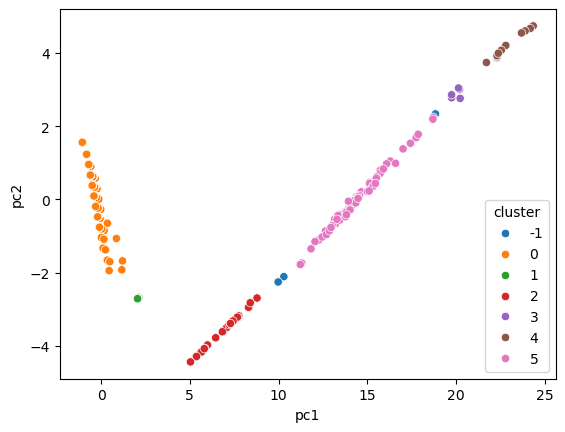

In [61]:
print(clustered_df)

sns.scatterplot(data=clustered_df, y='pc2', x='pc1', hue='cluster', palette=sns.color_palette("tab10"))

Checking _heatmap.png


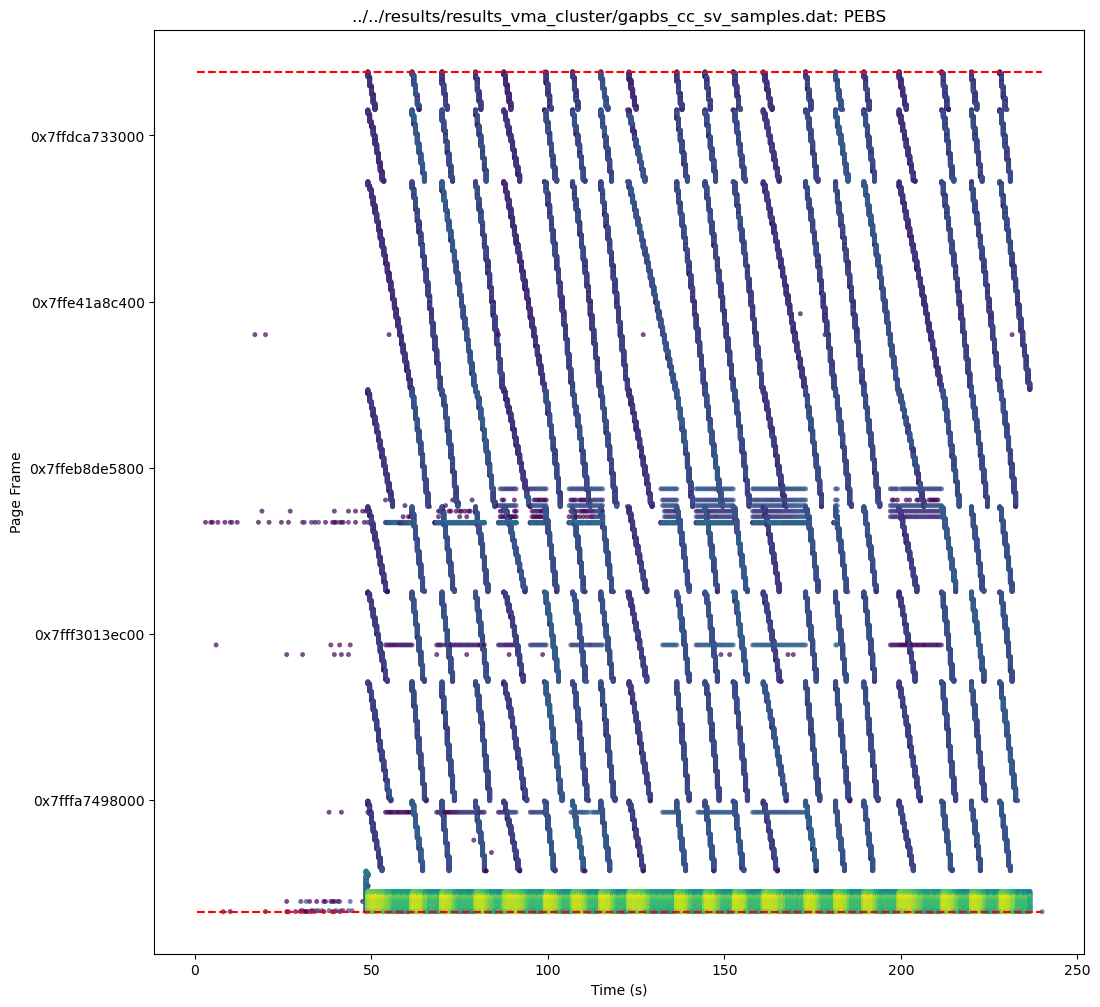

In [62]:
def _prepare_pebs_df(file):
    # Read the file line by line
    with open(file) as f:
        rows = [line.strip().split() for line in f if line.strip()]

    # Find the maximum number of columns in any row
    max_cols = max(len(row) for row in rows)

    # Pad each row so all have the same length
    #padded_rows = [row + [np.nan]*(max_cols - len(row)) for row in rows]

    # Function to pad each row with the last recorded value
    def pad_row(row, target_length):
        if len(row) < target_length:
            last_value = row[-1]
            # Extend the row with the last_value until it reaches the target length
            row = row + [last_value] * (target_length - len(row))
        return row

    # Pad each row accordingly
    padded_rows = [pad_row(row, max_cols) for row in rows]

    # Create a DataFrame
    df = pd.DataFrame(padded_rows)

    # Rename columns: first column as 'PageFrame' and remaining as 'Epoch1', 'Epoch2', ...
    df.rename(columns={0: "PageFrame"}, inplace=True)
    df.columns = ["PageFrame"] + [f"Epoch_{i}" for i in range(1, max_cols)]

    df["PageFrame"] = df["PageFrame"].apply(lambda x: hex(int(x, 16) << 21))

    # Convert epoch columns to numeric
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col])


    # Set PageFrame as index for easier time-series operations
    df.set_index("PageFrame", inplace=True)

    df = df.copy() # Improves performance? df is sparse otherwise

    # Compute the deltas across epochs
    delta_df = df.diff(axis=1)

    # For the first epoch, fill NaN with the original epoch value
    first_epoch = df.columns[0]
    delta_df[first_epoch] = df[first_epoch]

    # Reorder columns to ensure the first epoch is first
    delta_df = delta_df[df.columns]

    # Optional: Convert column names to a numeric index if desired
    # For plotting purposes, we can remove the 'Epoch_' prefix and convert to int
    delta_df.columns = [int(col.replace("Epoch_", ""))*0.5 for col in delta_df.columns]

    # If we want to use plt instead of sns, melt df into long form
    #df_long = (
    #    delta_df
    #    .reset_index()
    #    .melt(id_vars=["PageFrame"], var_name="epoch", value_name="value")
    #)
    #df_long["PageFrame"] = df_long["PageFrame"].apply(lambda x: int(x,16))
    #return df_long

    return delta_df

def generate_pebs_figure(file, output_path):

    output_file = output_path + "_heatmap.png"
    print("Checking {}".format(output_file))

    if os.path.isfile(output_file):
        print("Skipping {}".format(output_file))
        return

    df = prepare_pebs_df(file)
    plt.figure(figsize=(12, 12))
    #sns.heatmap(df, cmap="viridis", cbar=True, norm=LogNorm())

    xmin = df['epoch'].min()
    xmax = df['epoch'].max()
    
    # Draw a horizontal line at y = some_value
    ymax = time_bin_df1['PageFrame'].max()
    ymin = time_bin_df1['PageFrame'].min()
    plt.hlines(y=ymax, xmin=xmin, xmax=xmax, colors='red', linestyles='dashed')
    plt.hlines(y=ymin, xmin=xmin, xmax=xmax, colors='red', linestyles='dashed')

    df = df[df['PageFrame'] >= ymin]
    df = df[df['PageFrame'] <= ymax]
    # If we want to use plt instead of sns
    plt.scatter(df['epoch'], df['PageFrame'], c=df['value'], s=50, norm=LogNorm(), edgecolor='none', rasterized=True, alpha=0.7, marker='.')


    ax = plt.gca()
    ## 1) Define a hex‐formatter: takes a float x and returns e.g. '0x1a3f'
    hex_formatter = FuncFormatter(lambda x, pos: hex(int(x)))

    ## 2) Install it on the y‐axis
    ax.yaxis.set_major_formatter(hex_formatter)
    ax.invert_yaxis()

    plt.xlabel("Time (s)")
    plt.ylabel("Page Frame")
    plt.title(file + ": PEBS")
    plt.show()
    #plt.savefig(output_file, dpi=300, bbox_inches="tight")

generate_pebs_figure('../../results/results_vma_cluster/gapbs_cc_sv_samples.dat', '')

In [10]:





#vma_stat_df = page_stat_df.groupby('rno').agg(
#        {
##            'duty_cycle_percent': ['count', 'mean', 'std', 'min', 'max'],
#            'reuse_distance': ['count', 'mean', 'std', 'min', 'max']
#        }
#    )

#filtered_vma_df = vma_df
#filtered_vma_df = vma_df[vma_df['pathname'] == pd.NA]

#vma_stat_df.columns = ['_'.join(col) for col in vma_stat_df.columns]
#vma_stat_df = vma_stat_df.reset_index()
#vma_stat_df = pd.merge(vma_stat_df, filtered_vma_df, on='rno', how='left')
#vma_stat_df['rss_kb_percent'] = vma_stat_df['rss_kb'] / vma_stat_df['size']
#vma_stat_df['pss_kb_dirty_percent'] = vma_stat_df['pss_dirty'] / vma_stat_df['pss_kb']
#print(vma_stat_df)

In [11]:
# Filter out VMAs

In [12]:
#vma_stat_df = vma_stat_df.loc[vma_stat_df.groupby('rno')['size'].idxmax()]
#print(vma_stat_df.reset_index(drop=True).drop(columns=['epoch', 'start', 'end', 'inode', 'pathname', 'rss_kb', 'pss_kb', 'pss_dirty', 'referenced']))